In [11]:
# Import libraries
from Bio.PDB import PDBParser # for parsing input structure
from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters,minimize,report_fit # fot fitting helix
import io # for printing output to file
from contextlib import redirect_stdout # for printing output to file
import tempfile
import os

import pyrosetta
#from rosetta import *
pyrosetta.init("-beta_nov16 -mute all")
import pandas as pd
import copy

PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2019.19.post.dev+17.commits.d5a7d8129801bf7eaf383dba4ad48c78085ffd42 2019-05-20T01:48:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [12]:
def find_helix_coords(pose, min_len=3):
    """Given a secondary strucure asignmet, count the number of helices (at least as long as min_len)
    """
    
    if min_len < 1:
        raise ValueError
    
    pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
    
    all_helix_resis=[]
    
    
    for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
        current_helix_resis=[]
        
        for res_num in pyrosetta.rosetta.core.pose.get_resnums_for_chain_id(pose,chain):
            res_ss = pose.secstruct(res_num)
            if res_ss == 'H':
                current_helix_resis.append(res_num)
            else:
                if len(current_helix_resis) >= min_len:
                    all_helix_resis.append(current_helix_resis)
                current_helix_resis = []
        if len(current_helix_resis) >= min_len:
            all_helix_resis.append(current_helix_resis)
    
    #now I need to convert those resis to Calpha coords
    all_helix_coords = []
    for helix in all_helix_resis:
        helix_coords = []
        for res_id in helix:
            
            res = pose.residue(res_id)
            ca = res.atom("CA")
            x,y,z = ca.xyz()
            x = float(x)
            y = float(y)
            z = float(z)
            helix_coords.append([x,y,z])
        arr_helix_coords = np.array(helix_coords)
        all_helix_coords.append(arr_helix_coords)
    return all_helix_coords

In [35]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

# Calculates Rotation Matrix given euler angles and back.
#https://www.learnopencv.com/rotation-matrix-to-euler-angles/
def euler_to_R(phi,theta,psi):
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         np.cos(phi), -np.sin(phi) ],
                    [0,         np.sin(phi), np.cos(phi)  ]
                    ])

    R_y = np.array([[np.cos(theta),    0,      np.sin(theta)  ],
                    [0,                     1,      0                   ],
                    [-np.sin(theta),   0,      np.cos(theta)  ]
                    ])

    R_z = np.array([[np.cos(psi),    -np.sin(psi),    0],
                    [np.sin(psi),    np.cos(psi),     0],
                    [0,                     0,                      1]
                    ])

    R = np.dot(R_z, np.dot( R_y, R_x ))

    return R


def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def R_to_euler(R) :
    assert(isRotationMatrix(R))

    s_y = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])

    singular = s_y < 1e-6

    if  not singular :
        phi = np.arctan2(R[2,1] , R[2,2])
        theta = np.arctan2(-R[2,0], s_y)
        psi = np.arctan2(R[1,0], R[0,0])
    else :
        phi = np.arctan2(-R[1,2], R[1,1])
        theta = np.arctan2(-R[2,0], s_y)
        psi = 0

    return np.array([phi, theta, psi])


def rotation(u,v):
    #a = np.array([0,0,1])
    #b = random_tilt_u(sigma)
    a = normalize(u)
    b = normalize(v)
    
    v = np.cross(a,b)
    s = np.linalg.norm(v) #?
    c = a.dot(b)
    I = np.identity(3)
    
    #vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0, -v[2], v[1], v[2], 0, -v[0], -v[1], v[0], 0)
    #k = np.matrix(vXStr)
    
    k = np.array([[0 , -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    
    R = I + k + np.matmul(k,k) * ((1 -c)/(s**2))
    assert(isRotationMatrix(R))
    return R


u = [0,0,1]
v = normalize([1,1,1])
R1 = rotation(u,v)
print(R1)
print(R1.dot(u),v)




class HelixParameters():
    def __init__(self,r0=None,omega0=None,omega1=None,phi0=None,phi1=None,delta_z=None,invert=None,helix_length=None,z_aligned=False,translate_x=None,translate_y=None,translate_z=None,rotate_phi=None,rotate_theta=None,rotate_psi=None):
        self._r0,self._omega0,self._omega1,self._phi0,self._phi1,self._delta_z,self._invert,self._length,self._d,self._r1 = (None,)*10
        
        self._translate_x, self._translate_y, self._translate_z, self._rotate_phi, self._rotate_theta,self._rotate_psi = (None,)*6
        
        self.r0(r0)
        self.omega0(omega0)
        self.omega1(omega1)
        self.phi0(phi0)
        self.phi1(phi1)
        self.delta_z(delta_z)
        self.invert(invert)
        self.length(helix_length)
        self._d = 1.51 # FIXED, distance between successive residues along the helical axis, [angstrom] -- BundleGridSampler=z1
        self._r1 = 2.26 # FIXED, helical radius, [angstrom] -- BundleGridSampler=r1_peratom        
        
        self.z_aligned = z_aligned
        
        if self.z_aligned and any([translate_x,translate_y,translate_z,rotate_phi,rotate_theta,rotate_psi]):
            raise ValueError("no transformation parameters are allowed in z_aligned mode")
        
        if not self.z_aligned:
            self.translate_x(translate_x)
            self.translate_y(translate_y)
            self.translate_z(translate_z)
            self.rotate_phi(rotate_phi)
            self.rotate_theta(rotate_theta)
            self.rotate_psi(rotate_psi)
    
    def __repr__(self):
        return f'Helical Parameters: r0={self.r0()},omega0={self.omega0()},omega1={self.omega1()},phi0={self.phi0()},' \
               f'phi1={self.phi1()},delta_z={self.delta_z()},d={self.d()},r1={self.r1()},' \
               f'translate_x={self.translate_x()},translate_y={self.translate_y()},translate_z={self.translate_z()},' \
               f'rotate_phi={self.rotate_phi()},rotate_theta={self.rotate_theta()},rotate_psi={self.rotate_psi()},' \
               f'invert={self.invert()},length={self.length()}'
    
    #hybrid setters/getters. They will always return the value you ask for, but if you pass 
    #something to the function, it'll update the stored value and then return the (updated) value
    def r0(self,r0:float=None):
        if r0 is not None:
            assert(r0 >0)
            #assert(r0 <= 20)
            self._r0 = r0
        return self._r0
        
    def omega0(self,omega0:float=None):
        if omega0 is not None:
            self._omega0 = omega0
        return self._omega0
            
    def omega1(self,omega1:float=None):    
        if omega1 is not None:
            self._omega1 = omega1
        return self._omega1
    
    def phi0(self,phi0:float=None):
        if phi0 is not None:
            assert(phi0 >= 0) #enforece pos only
            self._phi0 = phi0
        return self._phi0
    
    def phi1(self,phi1:float=None):
        if phi1 is not None:
            self._phi1 = phi1
        return self._phi1
    
    def delta_z(self,delta_z:float=None):
        if delta_z is not None:
            self._delta_z = delta_z
        return self._delta_z
    
    def invert(self,invert:bool=None):
        if invert is not None:
            self._invert = invert
        return self._invert
    
    def length(self,length:int=None):
        if length is not None:
            self._length = length
        return self._length
    
    def d(self,d:float=None):
        if d is not None:
            warnings.warn("HelixParamaters variable d is a physical constraint should not be touched")
            self._d = d
        return self._d
    
    def r1(self,r1:float=None):
        if r1 is not None:
            warnings.warn("HelixParamaters variable r1 is a physical constraint should not be touched")
            self._r1 = r1
        return self._r1
    
    
    #new axis independent code
    def translate_x(self,x:float=None):
        if x is not None:
            self._translate_x = x
        #print(f"self._translate_x: {self._translate_x}")
        return self._translate_x
    
    def translate_y(self,y:float=None):
        if y is not None:
            self._translate_y = y
        #print(f"self._translate_y: {self._translate_y}")
        return self._translate_y
    
    def translate_z(self,z:float=None):
        if z is not None:
            self._translate_z = z
        #print(f"self._translate_z: {self._translate_z}")
        return self._translate_z
    
    def rotate_phi(self,phi:float=None):
        if phi is not None:
            self._rotate_phi = phi
        #print(f"self._rotate_phi: {self._rotate_phi}")
        return self._rotate_phi
    
    def rotate_theta(self,theta:float=None):
        if theta is not None:
            self._rotate_theta = theta
        #print(f"self._rotate_theta: {self._rotate_theta}")
        return self._rotate_theta
    
    def rotate_psi(self,psi:float=None):
        if psi is not None:
            self._rotate_psi = psi
        #print(f"self._rotate_psi: {self._rotate_psi}")
        return self._rotate_psi
    
    def transformation_matrix(self):
        if self.z_aligned:
            return np.identity(4)
            
            
        R = euler_to_R(self.rotate_phi(),self.rotate_theta(),self.rotate_psi())
        #print(R)
        #R.resize(4,4)
        M = np.append(np.append(R,[[0]*3],axis=0),[[0]]*4,axis=1)
        #print(M)
        M[3][3] = 1
        M[0][3] = self.translate_x()
        M[1][3] = self.translate_y()
        M[2][3] = self.translate_z()
        #print(M)
        return M
    
    def to_lmfit_parameters(self, round_num=None):
        if self.z_aligned and round_num is not None:
            raise ValueError("z aligned mode only has one round. Just don't set round_num")
        
        if self.z_aligned:
            params = Parameters()
            params.add('r0', value=self.r0(), min=0.000001, max=40, vary=True) # avoid negative radii
            params.add('omega0', value=self.omega0(), vary=True)
            params.add('omega1', value=self.omega1(),  vary=True)
            params.add('phi0', value=self.phi0(), min=0,vary=True) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=True)
            params.add('invert', value=self.invert(), vary=False)
            
            return params
        
        if round_num is None:
            params = Parameters()
            params.add('r0', value=self.r0(), min=0.0000000001, max=20, vary=True) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=True)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=True) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)")
            params.add('phi0', value=self.phi0(), min=0,vary=False) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #r0*omega0 = d * sin(alpha)





        
            return params
        
        elif round_num == 1:
            params = Parameters()
            params.add('r0', value=self.r0(), min=5, max=20, vary=False) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=False)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=False) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)",vary=False)
            params.add('phi0', value=self.phi0(), min=0,vary=False) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #axis independent code:
            params.add('translate_x', value=self.translate_x(),vary=True)
            params.add('translate_y', value=self.translate_y(),vary=True)
            params.add('translate_z', value=self.translate_z(),vary=True)
            params.add('rotate_phi', value=self.rotate_phi(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_theta', value=self.rotate_theta(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_psi',value=self.rotate_psi(),min=-np.pi,max=np.pi,vary=True)
        
            return params
        
        elif round_num == 2:
            params = Parameters()
            params.add('r0', value=self.r0(), min=5, max=20, vary=True) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=True)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=True) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)",vary=True)
            params.add('phi0', value=self.phi0(), min=0,vary=True) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #axis independent code:
            params.add('translate_x', value=self.translate_x(),vary=False)
            params.add('translate_y', value=self.translate_y(),vary=False)
            params.add('translate_z', value=self.translate_z(),vary=False)
            params.add('rotate_phi', value=self.rotate_phi(),min=-np.pi,max=np.pi,vary=False)
            params.add('rotate_theta', value=self.rotate_theta(),min=-np.pi,max=np.pi,vary=False)
            params.add('rotate_psi',value=self.rotate_psi(),min=-np.pi,max=np.pi,vary=False)
        
            return params
        
        elif round_num == 3:
            params = Parameters()
            params.add('r0', value=self.r0(), min=5, max=20, vary=True) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=True)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=True) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)")
            params.add('phi0', value=self.phi0(), min=0,vary=False) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #r0*omega0 = d * sin(alpha)




            #axis independent code:
            params.add('translate_x', value=self.translate_x(),vary=True)
            params.add('translate_y', value=self.translate_y(),vary=True)
            params.add('translate_z', value=self.translate_z(),vary=True)
            params.add('rotate_phi', value=self.rotate_phi(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_theta', value=self.rotate_theta(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_psi',value=self.rotate_psi(),min=-np.pi,max=np.pi,vary=True)
        
            return params
        else:
            print(f"round_num {round_num} not recognized")
            return None
    
    
    def from_lmfit(self, fit):
        self.r0(fit.valuesdict()['r0'])
        self.omega0(fit.valuesdict()['omega0'])
        self.omega1(fit.valuesdict()['omega1'])
        self.phi0(fit.valuesdict()['phi0'])
        self.phi1(fit.valuesdict()['phi1'])
        self.delta_z(fit.valuesdict()['delta_z'])
        self.invert(fit.valuesdict()['invert'])
        
        if not self.z_aligned:

            self.translate_x(fit.valuesdict()['translate_x'])
            self.translate_y(fit.valuesdict()['translate_y'])
            self.translate_z(fit.valuesdict()['translate_z'])
            self.rotate_phi(fit.valuesdict()['rotate_phi'])
            self.rotate_theta(fit.valuesdict()['rotate_theta'])
            self.rotate_psi(fit.valuesdict()['rotate_psi'])
        
       
    def get_dict(self):
        d = {
            'r0':self.r0(),
            'omega0':self.omega0(),
            'omega1':self.omega1(),
            'phi0':self.phi0(),
            'phi1':self.phi1(),
            'delta_z':self.delta_z(),
            'd':self.d(),
            'r1':self.r1(),
            'translate_x':self.translate_x(),
            'translate_y':self.translate_y(),
            'translate_z':self.translate_z(),
            'rotate_phi':self.rotate_phi(),
            'rotate_theta':self.rotate_theta(),
            'rotate_psi':self.rotate_psi(),
            'invert':self.invert(),
            'length':self.length()
        }
        
        return d

import warnings 

class ParametricFit():
    def __init__(self, name, fit=None, write_axis=False):
        self._name = None
        self.write_axis = write_axis
        if self.write_axis:
            self.axis_movie = []
        self.fit = pd.DataFrame()
        self.coordinate_movie = []
        self.rmsd = []
        self.parameter_history=[]
        if name is None:
            name = "parametric_fit"
        self.name(name)

        if fit is not None:
            self.parse_fit(fit)
            
    #this really should only be accessed by the ParametricHelix class
    #take a fit and 
    def parse_fit(self, fit):
        self.fit = fit
        warnings.warn("PARSE_FIT NOT IMPLEMENTED")
    
    def name(self,name:str=None):
        if name is not None:
            self._name = name
        return self._name
    
    def append_trajectory_rmsd(self,rmsd):
        self.rmsd.append(rmsd)

    def append_trajectory_coords(self,coords, axis=None):
        self.coordinate_movie.append(coords)
        if self.write_axis:
            self.axis_movie.append(axis)

    def write_trajectory_movie(self, filename):
        # Generate movie PDB of fitting trajectories
        f=open(filename,'w')
        model=1
        for coord_frame,ax_frame in zip(self.coordinate_movie,self.axis_movie):
            resid=1
            atomnumb=2
            f.write('MODEL{:>8s}\n'.format(str(model)))  
            for i in coord_frame:
                f.write('ATOM{:>7s}  CA  ALA A{:>4s}     {:>7.3f} {:>7.3f} {:>7.3f}  1.00  0.00           C\n'.format(str(atomnumb),str(resid),float(i[0]),float(i[1]),float(i[2])))
                resid=resid+1
                atomnumb=atomnumb+10
            if self.write_axis:
                for i in ax_frame:
                    f.write('ATOM{:>7s}  CA  ALA B{:>4s}     {:>7.3f} {:>7.3f} {:>7.3f}  1.00  0.00           C\n'.format(str(atomnumb),str(resid),float(i[0]),float(i[1]),float(i[2])))
                    resid=resid+1
                    atomnumb=atomnumb+10
            f.write('TER\n')
            f.write('ENDMDL\n')
            model=model+1
        f.write('END')
        f.close()

    def plot_trajectory_rmsd(self, ax=None):
        # Plot minimization trajectories
        
        if ax is None:
            fig, ax = plt.subplots()
        #warning, don't know how to get fig if ax is passed to us. Do I need fig? probably not
        plt.plot(self.rmsd, axes=ax, label=self.name())
        ax.set_title('Minimization trajectory')
        ax.set_xlabel('Minimization steps')
        ax.set_ylabel('RMSD ($\AA$)')
        plt.legend(loc='best')
        print("final rmsd: " + str(self.rmsd[-1]))
        return ax
    
    def plot_trajectory_parameter(self, parameter:str=None, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        #warning, don't know how to get fig if ax is passed to us. Do I need fig? probably not

        data = [timepoint[parameter] for timepoint in self.parameter_history]
        plt.plot(data, axes=ax, label=self.name())
        ax.set_title('Minimization trajectory for ' + parameter)
        ax.set_xlabel('Minimization steps')
        ax.set_ylabel('parameter value')
        plt.legend(loc='best')
        return ax
    
    def append_trajectory_parameters(self,hp:HelixParameters=None):
        self.parameter_history.append(hp.get_dict())
    




class ParametricHelix():
    def __init__(self,name:str=None,z_aligned:bool=False):
        self.helix_parameters = HelixParameters()
        self._name = None
        self.name(name)
        self.z_aligned = z_aligned
    
    def name(self,name:str=None):
        if name is not None:
            self._name = name
        return self._name
    
    def is_named(self):
        return self._name is not None
    
    def get_helix_parameters(self):
        #may want to make this a deep copy? 
        return self.helix_parameters

    #### FUNCTIONS ####

    # Parametric helix equation based on Huang et al. equations as described in SI 
    # Contains small patch to make it compatible with BundleGridSampler mover (due to differences in origin definition)

    #----------MAKE CARTESIAN COORDINATES FOR CA OF RESIDUE t---------------
    def cartesian(self,t):
    #def cartesian(r0, omega0, omega1, phi0, phi1, delta_z):
        
        # d AND r1 SHOULD NOT BE VARIED IF WANT TO RETAIN IDEAL ALPHA-HELIX
        d = self.helix_parameters.d()
        r1 = self.helix_parameters.r1()
        r0 = self.helix_parameters.r0()
        omega0 = self.helix_parameters.omega0()
        omega1 = self.helix_parameters.omega1()
        phi0 = self.helix_parameters.phi0()
        phi1 = self.helix_parameters.phi1()
        delta_z = self.helix_parameters.delta_z()

        # ONLY FUNCTIONS OF OTHER PARAMETERS
        pre_asin = np.clip((r0*omega0)/d,-1,1) #ryan added this hack
        alpha=asin(pre_asin) # CONSTRAINED (function of other variables), pitch angle, [radians] -- BundleGridSampler=delta_omega1_peratom?
        phi_prime0=phi0+delta_z*tan(alpha)/r0 # CONSTRAINED (function of other variables), superhelical phase decoupled from delta_z, [radians] 

        x=r0*cos(omega0*t+phi_prime0)+r1*cos(omega0*t+phi_prime0)*cos(omega1*t+phi1)-r1*cos(alpha)*sin(omega0*t+phi_prime0)*sin(omega1*t+phi1)
        y=r0*sin(omega0*t+phi_prime0)+r1*sin(omega0*t+phi_prime0)*cos(omega1*t+phi1)+r1*cos(alpha)*cos(omega0*t+phi_prime0)*sin(omega1*t+phi1)
        z=((omega0*r0)/(tan(alpha)))*t-r1*sin(alpha)*sin(omega1*t+phi1)+delta_z

        return [x,y,z]


    #---------MAKE ARRAY OF XYZ COORDINATES FOR ALL CA-----------------------
    #residue_indices would be given like Huang's convention but 0 indexed (0 = first res). Going under the first res means negative numbers
    def moving(self,residue_indices=None):
        
        if residue_indices is None:
            # PATCH TO BRIDGE DIFFERENCES IN HOW THE 'ORIGIN' IS DEFINED
            delta_t=int(self.helix_parameters.length()/2)# define an offset of half-helix length (in number of residues) -- BundleGridSampler=delta_t
            # 're-number' indices +/- around middle of helix
            # to patch Vikram's convention (start from middle of helix) and Huang's convention (start at resid 1) 

            
            
            # Correct for helices that have odd numbers of residues (otherwise fitting helix will be one residue short)
            if (self.helix_parameters.length() % 2) == 0:
                residue_renumber_indices=np.arange(-delta_t,+delta_t,1)
            if (self.helix_parameters.length() % 2) != 0:
                residue_renumber_indices=np.arange(-delta_t,+delta_t+1,1)


            
        
        else:
            
            residue_renumber_indices = residue_indices
            print('this is almost certainly not what I wnat to do') #gosh I wish I could remember what this note was here for
        
        
        if self.helix_parameters.invert(): # change direction of helix
                residue_renumber_indices=-1*residue_renumber_indices
        
        
        moving_coordinates = np.array([self.cartesian(t) for t in residue_renumber_indices])

        return moving_coordinates



    
    def Ca_coords_from_stored_params(self,axis=False,residue_indices=None):
        #print("Ca_coords_from_stored_params")
        #print("residue_indices")
        #print(residue_indices)
        move = self.moving(residue_indices)
        #print("move")
        #print(move)
        padded_move = np.append(move,[[1]]*move.shape[0], axis = 1)
        transformed = self.helix_parameters.transformation_matrix().dot(padded_move.T).T
        striped_transformed = np.delete(transformed,3,axis=1)
        
        
        if axis:
            axis = np.array([[0,0,-10],[0,0,10]])
            padded_axis = np.append(axis,[[1]]*axis.shape[0], axis = 1)
            transformed_axis = self.helix_parameters.transformation_matrix().dot(padded_axis.T).T
            striped_axis = np.delete(transformed_axis,3,axis=1)
            
            return striped_transformed, striped_axis
        else:
            return striped_transformed
    
#-----------Objective RMSD function used during minimization---------------    
    def rmsd_array(self,params, target, dummy):
#         r0=params['r0']
#         omega0=params['omega0'] 
#         omega1=params['omega1'] 
#         phi0=params['phi0']
#         phi1=params['phi1'] 
#         delta_z=params['delta_z']
#         invert=params['invert']
        self.helix_parameters.from_lmfit(params)
        
#         move = self.moving()
        
#         axis = np.array([[0,0,-10],[0,0,10]])
        
#         #print(move)
#         #print(move.shape)
#         padded_move = np.append(move,[[1]]*move.shape[0], axis = 1)
#         padded_axis = np.append(axis,[[1]]*axis.shape[0], axis = 1)
#         #print(padded_move)
#         #print(self.helix_parameters.transformation_matrix())
#         transformed = self.helix_parameters.transformation_matrix().dot(padded_move.T).T
#         transformed_axis = self.helix_parameters.transformation_matrix().dot(padded_axis.T).T
#         #print(transformed)
        
#         striped_transformed = np.delete(transformed,3,axis=1)
#         striped_axis = np.delete(transformed_axis,3,axis=1)
#         #print(striped_transformed)
        striped_transformed,striped_axis = self.Ca_coords_from_stored_params(axis=True)
        
        subtract_coord=striped_transformed-target

        rmsd_array=np.sqrt(np.sum(np.power(subtract_coord,2),axis=1))
        rmsd=np.sqrt((1/self.helix_parameters.length())*np.sum(np.sum(np.power(subtract_coord,2),axis=1)))
        
        self.fit.append_trajectory_rmsd(rmsd)
        self.fit.append_trajectory_coords(striped_transformed,striped_axis)
        self.fit.append_trajectory_parameters(self.helix_parameters)

        print(f'rmsd={rmsd}')
        
        return rmsd_array
    
    
    #meant for users to use
    #pose is assumed to be a single helix that I want to know about
    def fit_target_helix(self,pose, write_axis=False):
        if(not self.z_aligned):
    #         self.fit = ParametricFit(self.name(),write_axis=write_axis)

    #         #this gets all the coordinates. I only need Calphas
    #         #target_coords = [ [ pose.residue( r.xyz(a)) for a in range(1, pose.residue(r).natoms() + 1)] for r in range(1, pose.total_residue() + 1)]

    #         target_helix = np.array([np.array(pose.residue(r).atom("CA").xyz()) for r in range(1, pose.total_residue() + 1)])

    #         helix_length=len(target_helix) # number of residues in the helix, [aa]

    #         # not 100% sure this code will be necessary after the coordinate independence upgrade
    #         if (target_helix[-1]-target_helix[0])[2]<0: # check helix orientation
    #             invert=True
    #         else:
    #             invert=False

    #         #some guesses
    #         r0_guess=0.00001 # VARY, superhelical radius, [angstrom] -- BundleGridSampler=r0
    #         delta_z_guess=0 # VARY, offest along the z axis, [angstrom] -- BundleGridSampler=z0_offset
    #         phi1_guess=radians(0) # VARY, helical phase (around the internal axis of that helix), [degrees] -- BundleGridSampler=delta_omega1
    #         #phi0_guess=radians(180) # FIXED? superhelical phase, i.e. 0, 90, 180, 270 for 4 evenly spaced helices, [degrees] -- BundleGridSampler=delta_omega0
    #         omega0_guess=radians(-2.85) # FIXED? superhelical twist (-2.85 degrees for two layers), relates to omega1, [degrees] -- BundleGridSampler=omega0
    #         omega1_guess=radians(+102.85) # FIXED? helical twist (+102.85 degrees for two layers), relates to omega0, [degrees] -- BundleGridSampler=omega1

    #         # Generate quick estimates of phi0 to pass as better guess to avoid convergence problems and math domain errors
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant I
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant II
    #             phi0_guess=radians(180-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant III
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0])))+180)
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant IV
    #             phi0_guess=radians(360-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))

    #         phi0_guess=0

    # #         #guess about transform        
    # #         translate_x_guess = 0
    # #         translate_y_guess = 0
    # #         translate_z_guess = 0
    # #         rotate_phi_guess = 0
    # #         rotate_theta_guess = 0
    # #         rotate_psi_guess = 0

    #         #I can do better than that
    #         helical_pseudo_axis = normalize(target_helix[-1] - target_helix[0])
    #         helical_pseudo_origin = (target_helix[0] + target_helix[-1])/2
    #         #print(target_helix[0],target_helix[-1],helical_pseudo_axis,helical_pseudo_origin)
    #         exit("something about the pseduo_axis is bad")
    #         rotate_phi_guess,rotate_theta_guess,rotate_psi_guess = R_to_euler(rotation(helical_pseudo_axis,[0,0,-1]))
    #         translate_x_guess,translate_y_guess,translate_z_guess = helical_pseudo_origin



    #         #input guesses
    #         self.helix_parameters=HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert,helix_length,translate_x_guess,translate_y_guess,translate_z_guess,rotate_phi_guess,rotate_theta_guess,rotate_psi_guess)

    #         #-----GENERATE PARAMETER DICTIONARY-----------



    #         params = self.helix_parameters.to_lmfit_parameters()

    #         # FIT
    #         fit=minimize(self.rmsd_array,params,method='bfgs',args=(target_helix,True),**{"options":{"maxiter":1000}}) #,**{"ftol":1.e-3}


    #         #self.helix_parameters.from_lmfit(fit)

    #         self.fit.parse_fit(fit)



            #3 step fitting
            #1) using a slightly supercoiled helix, fit the transform, everything else fixed
            #2) using the fitted transform as fixed variables, fit the helical parameters
            #3) fit everything,initialized with previous fits, to work out kinks


            self.fit = ParametricFit(self.name(),write_axis=write_axis)

            #this gets all the coordinates. I only need Calphas
            #target_coords = [ [ pose.residue( r.xyz(a)) for a in range(1, pose.residue(r).natoms() + 1)] for r in range(1, pose.total_residue() + 1)]

            target_helix = np.array([np.array(pose.residue(r).atom("CA").xyz()) for r in range(1, pose.total_residue() + 1)])

            helix_length=len(target_helix) # number of residues in the helix, [aa]

    #         # not 100% sure this code will be necessary after the coordinate independence upgrade
    #         if (target_helix[-1]-target_helix[0])[2]<0: # check helix orientation
    #             invert=True
    #         else:
    #             invert=False
            invert_guess=True

            #some guesses
            r0_guess=5 # VARY, superhelical radius, [angstrom] -- BundleGridSampler=r0
            delta_z_guess=0 # VARY, offest along the z axis, [angstrom] -- BundleGridSampler=z0_offset
            phi1_guess=radians(0) # VARY, helical phase (around the internal axis of that helix), [degrees] -- BundleGridSampler=delta_omega1
            #phi0_guess=radians(180) # FIXED? superhelical phase, i.e. 0, 90, 180, 270 for 4 evenly spaced helices, [degrees] -- BundleGridSampler=delta_omega0
            omega0_guess=radians(-2.85) # FIXED? superhelical twist (-2.85 degrees for two layers), relates to omega1, [degrees] -- BundleGridSampler=omega0
            omega1_guess=radians(+102.85) # FIXED? helical twist (+102.85 degrees for two layers), relates to omega0, [degrees] -- BundleGridSampler=omega1


            #make estimates of phi0 using a target helix aligned to z

    #         # Generate quick estimates of phi0 to pass as better guess to avoid convergence problems and math domain errors
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant I
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant II
    #             phi0_guess=radians(180-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant III
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0])))+180)
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant IV
    #             phi0_guess=radians(360-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))

            phi0_guess=0#radians(90)

            #guess about transform        
    #         translate_x_guess = 0
    #         translate_y_guess = 0
    #         translate_z_guess = 0
    #         rotate_phi_guess = 0
    #         rotate_theta_guess = 0
    #         rotate_psi_guess = 0

    #         #I can do better than that
            helical_pseudo_axis = normalize(target_helix[-1] - target_helix[0])
            helical_pseudo_origin = (target_helix[0] + target_helix[-1])/2
            #print(target_helix[0],target_helix[-1],helical_pseudo_axis,helical_pseudo_origin)




            rotate_phi_guess,rotate_theta_guess,rotate_psi_guess = R_to_euler(rotation([0,0,-1],helical_pseudo_axis))
            translate_x_guess,translate_y_guess,translate_z_guess = helical_pseudo_origin


            #According to Basile and Nick, the transformation I use is actually degenerate over 180deg so it won't correclty account for fully inverted helices
            #to fix this, I present the following hack
            orig_hp = HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert_guess,helix_length,False,translate_x_guess,translate_y_guess,translate_z_guess,rotate_phi_guess,rotate_theta_guess,rotate_psi_guess)
            self.helix_parameters=orig_hp
    #         orig_init_helix = Ca_coords_from_stored_params()
    #         orig_subtract_coord=orig_init_helix-target
    #         original_rmsd=np.sqrt((1/self.helix_parameters.length())*np.sum(np.sum(np.power(orig_subtract_coord,2),axis=1)))

    #         invert_hp = orig_hp = HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert_guess,helix_length,translate_x_guess,translate_y_guess,translate_z_guess,rotate_phi_guess,rotate_theta_guess,rotate_psi_guess)
    #         #wait, let's just try this

            #input guesses


            # FIT
            print("BEGIN ROUND 1")
            params = self.helix_parameters.to_lmfit_parameters(round_num=1)
            #fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-9}) #"maxiter":1000 #,**{"ftol":1.e-3}
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1.0e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
            self.helix_parameters.from_lmfit(fit.params)#retrieve last fit #not necessary I think

            print("BEGIN ROUND 2")
            params = self.helix_parameters.to_lmfit_parameters(round_num=2)
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{'ftol':1.0e-3})#,**{"options":{"maxiter":1000}}) #,**{"ftol":1.e-3}
            self.helix_parameters.from_lmfit(fit.params)#retrieve last fit #not necessary I think

            print("BEGIN ROUND 3")
            params = self.helix_parameters.to_lmfit_parameters(round_num=3)
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1.0e-4})
            self.helix_parameters.from_lmfit(fit.params)#retrieve last fit #not necessary I think



    #         #standard protocol
    #         params = self.helix_parameters.to_lmfit_parameters(round_num=None)
    # #        fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
    #         fit=minimize(self.rmsd_array,params,method='bfgs',args=(target_helix,True),**{"options":{}}) #"maxiter":1000 #,**{"ftol":1.e-3}
    #         self.helix_parameters.from_lmfit(fit.params)





            self.fit.parse_fit(fit)



            return self.fit
        
        
        else:

            self.fit = ParametricFit(self.name(),write_axis=write_axis)

            #this gets all the coordinates. I only need Calphas
            target_helix = np.array([np.array(pose.residue(r).atom("CA").xyz()) for r in range(1, pose.total_residue() + 1)])

            helix_length=len(target_helix) # number of residues in the helix, [aa]

            if (target_helix[-1]-target_helix[0])[2]<0: # check helix orientation
                invert_guess=True
            else:
                invert_guess=False

            #some guesses
            r0_guess=5 # VARY, superhelical radius, [angstrom] -- BundleGridSampler=r0
            delta_z_guess=0 # VARY, offest along the z axis, [angstrom] -- BundleGridSampler=z0_offset
            phi1_guess=radians(0) # VARY, helical phase (around the internal axis of that helix), [degrees] -- BundleGridSampler=delta_omega1
            phi0_guess=radians(180) # FIXED? superhelical phase, i.e. 0, 90, 180, 270 for 4 evenly spaced helices, [degrees] -- BundleGridSampler=delta_omega0
            omega0_guess=radians(-2.85) # FIXED? superhelical twist (-2.85 degrees for two layers), relates to omega1, [degrees] -- BundleGridSampler=omega0
            omega1_guess=radians(+102.85) # FIXED? helical twist (+102.85 degrees for two layers), relates to omega0, [degrees] -- BundleGridSampler=omega1


            #make estimates of phi0 using a target helix aligned to z

            # Generate quick estimates of phi0 to pass as better guess to avoid convergence problems and math domain errors
            if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant I
                phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
            if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant II
                phi0_guess=radians(180-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
            if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant III
                phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0])))+180)
            if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant IV
                phi0_guess=radians(360-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))



       
            orig_hp = HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert_guess,helix_length,True)
            self.helix_parameters=orig_hp


            params = self.helix_parameters.to_lmfit_parameters()
#            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
            self.helix_parameters.from_lmfit(fit.params)
            self.fit.parse_fit(fit)
            return self.fit
            
            
            
            
            
            
            
            
            
    
    #assume it has ss
    def find_helices_in_chain(self,input_pose,chain,min_len=3):
        pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True) #for some reason the ss wasn't being stored? 
        #print(f"chain = {chain}")
        chain_helix_resis=[]
        current_helix_resis=[]

        for res_num in pyrosetta.rosetta.core.pose.get_resnums_for_chain_id(pose,chain):
            res_ss = pose.secstruct(res_num)
            if res_ss == 'H':
                current_helix_resis.append(res_num)
            else:
                if len(current_helix_resis) >= min_len:
                    chain_helix_resis.append(current_helix_resis)
                current_helix_resis = []
        if len(current_helix_resis) >= min_len:
            chain_helix_resis.append(current_helix_resis)
        return chain_helix_resis
    
    def extract_helix(self,input_pose,helix_number,min_len=3,extract_end:str=None,extract_range:int=None):
        #print(helix_number)
        pose = pyrosetta.Pose()
        pose.assign(input_pose)
        pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
        all_helix_resis=[]
        for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
            chain_helix_resis=self.find_helices_in_chain(pose,chain,min_len)
            all_helix_resis.extend(chain_helix_resis)
        #print(all_helix_resis)
        #rint(len(all_helix_resis))
        target_helix_resis = all_helix_resis[helix_number]

        
        if extract_range is not None:
            assert(extract_range >= 4) #if it's less than 11/3 I think we can't fit it 
            assert(extract_end is not None)
            if extract_end.lower() == "n":
                target_helix_resi_start = target_helix_resis[0]
                target_helix_resis_end = target_helix_resis[extract_range]
            elif extract_end.lower() == "c":
                target_helix_resi_start = target_helix_resis[-extract_range]
                target_helix_resis_end = target_helix_resis[-1]
        else:
            target_helix_resi_start = target_helix_resis[0]
            target_helix_resis_end = target_helix_resis[-1]
        
        krm = pyrosetta.rosetta.protocols.grafting.simple_movers.KeepRegionMover()
        krm.region(str(target_helix_resi_start),str(target_helix_resis_end))
        pose.dump_pdb("00_before.pdb")
        krm.apply(pose)
        pose.dump_pdb(f"01_isolated_helix_{helix_number}.pdb")
        return pose
    
    # Define 'stub' (from 3 atoms) - necessary for computing the transformation matrix that matches the structures 
    def stub(self,b,a,c): # a,b,c are the vectors of a, b, c with respect to the general coordinate frame
        e1=(a-b)/np.linalg.norm(a-b)
        e3=np.cross(e1,(c-b))/np.linalg.norm(np.cross(e1,(c-b)))
        e2=np.cross(e1,e3)/np.linalg.norm(np.cross(e1,e3))
        partial_matrix = np.array([e1,e2,e3,b]).T
        extra_line=np.array([[0,0,0,1]])
        stub_matrix=np.append(partial_matrix,extra_line,axis=0)
        return stub_matrix

    def pdb_str_from_Ca(self,Ca_coordinates):
            # Generate 'ideal' stub 
        stub_file=map(str.split,open('/home/bwicky/Design/add_buttressing_helix_to_zcon/ideal.pdb','r').readlines())

        atom=[]
        for line in stub_file:
            atom.append(np.array([float(line[6]),float(line[7]),float(line[8])]))

        ideal_stub=self.stub(atom[6],atom[1],atom[11]) # generate ideal stub from CA coordinates

        pdb_str = ""
        # Generate and write bb of generated helix based on its CA trace
        atom_num=1
        res_num=0 
        chain='A'
        CA_chain=Ca_coordinates[:,0:3]
        for res in range(1,len(CA_chain)-1):

            res_num=res_num+1
            actual_stub=self.stub(CA_chain[res],CA_chain[res-1],CA_chain[res+1]) # stub based on CA trace
            transform=np.matmul(actual_stub,np.linalg.inv(ideal_stub)) # find transformation matrix between ideal and actual stub

            # N
            coords=np.matmul(transform,np.append(atom[5],1))
            pdb_str += 'ATOM %6d  N   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           N\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # CA (use actual CA from trace rather than superimposed one)
            coords=CA_chain[res]
            # If want to use CA from ideal stub instead of actual CA
            # coords=np.matmul(transform,np.append(atom[6],1)) 
            pdb_str += 'ATOM %6d  CA  ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # (N)H
            coords=np.matmul(transform,np.append(atom[7],1))
            pdb_str += 'ATOM %6d  H   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           H\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # C(O)
            coords=np.dot(transform,np.append(atom[8],1))
            pdb_str += 'ATOM %6d  C   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # O
            coords=np.dot(transform,np.append(atom[9],1))
            pdb_str += 'ATOM %6d  O   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           O\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

        pdb_str += 'END'
        return pdb_str
    
    def pdb_str(self):
        return self.pdb_str_from_Ca(self.Ca_coords_from_stored_params())
    
    # Function that takes CA coordinates as input and return ideal helix backbone in a pose
    def pose_from_Ca(self,Ca_coordinates):
        pdb_str = self.pdb_str_from_Ca(Ca_coordinates)
        pose = pyrosetta.Pose()
        pyrosetta.rosetta.core.import_pose.pose_from_pdbstring(pose, pdb_str)
        return pose
    
    def pose(self):
        return self.pose_from_Ca(self.Ca_coords_from_stored_params())
    
    def set_helix_parameters(self,params:HelixParameters):
        self.helix_parameters = params

    #build range assumes the middle of the helix is residue 0 or -1(?). pos = N, neg = C
    #Sure, I could make this elegant. But will I? Nah
    def build_helix(self, start:int,stop:int): 
        assert(start < stop)
        #build helix, if not given start and stop
        return self.pose_from_Ca(self.Ca_coords_from_stored_params(residue_indices=np.arange(start,stop+1,1)))
    
    def terminal_helix_number(self,pose,target_chain,direction):
        pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
        all_helix_resis=[]
        for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
            chain_helix_resis=self.find_helices_in_chain(pose,chain)
            all_helix_resis.extend(chain_helix_resis)
            print(all_helix_resis)
            if chain == pyrosetta.rosetta.core.pose.get_chain_id_from_chain(target_chain,pose):
                if direction.lower() =='c':
                    return len(all_helix_resis)
                else:
                    return len(all_helix_resis) - len(chain_helix_resis)
        #something went wrong!
        print(f"target_chain {target_chain} not found!")
        return -1
    
    #this really only supports extending terminal helices. I don't want to have to 
    #consider the case of extending an internal helix. Therefore this mover will be fixed to 
    #extending terminal helices. This lets me assume that I can delete everything at the terminus
    def extend_terminal_helix(self,pose,chain,direction,num_extend,num_fit=None):
        print(f"I have chain={chain},direction={direction},num_extend={num_extend},and num_fit={num_fit}")
        helix_number = self.terminal_helix_number(pose,chain,direction)
        print(f"helix chosen: {helix_number}")
        target_helix = self.extract_helix(pose,helix_number,extract_end=direction,extract_range=num_fit)
        fit = self.fit_target_helix(target_helix)
        original_length = len(target_helix)

        #make the helix a little longer so I can have some wiggle room for making the fusion
        if direction.lower() == "c":
            #I don't think the length matters?
            adj_stop = (-original_length/2) + 6 
            adj_start = (-original_length/2) - num_extend

            
        elif direction.lower() == 'n':
            if original_length % 2 == 0: #even
                adj_stop = (original_length / 2) + num_extend
                adj_start = (original_length / 2) - 6
            else:#odd
                adj_stop = (original_length / 2) + 1 + num_extend
                adj_start = (original_length / 2) + 1 - 6
        else:
            exit(f"{direction} isn't a valid direction. Use 'N' or 'C'")
            
        print("building residue indices")
        print(adj_start,adj_stop)    
        residue_indices = np.arange(adj_start,adj_stop,1)
        print(residue_indices)
        Ca_helix_extension = self.Ca_coords_from_stored_params(residue_indices=residue_indices)
        pdb_str = self.pdb_str_from_Ca(Ca_helix_extension)
        temp_pdb = tempfile.NamedTemporaryFile(delete=False,dir="/net/scratch/rdkibler/",suffix=".pdb")
        temp_pdb.write(pdb_str.encode())
        temp_pdb.close() #tempfile not immediately deleted       
        
        
        
        print(temp_pdb.name)
        !cat {temp_pdb.name}
#         try:
#             pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(f"""
#                 <SCOREFXNS>
#                     <ScoreFunction name="sfxn_asym" weights="beta_nov16" symmetric="0" />
#                 </SCOREFXNS>
#                 <RESIDUE_SELECTORS>
#                 <True name="all" />
#                 </RESIDUE_SELECTORS>
#                 <MOVERS>
#                     <AddResidueLabel name="no_des" residue_selector="all" label="all" />
#                     <MergePDB name="mergePDB"
#                         attachment_termini="{direction.lower()}_term"
#                         chain="{chain}"
#                         overlap_length="4" 
#                         overlap_rmsd="0.5"
#                         attach_pdb="{temp_pdb.name}"
#                         design_range="0" 
#                         packing_range="0"
#                         overlap_scan_range_cmdLine_pose="4"
#                         overlap_scan_range_xml_pose="4"
#                         scorefxn="sfxn_asym" 
#                         no_design_label="all"
#                         init_overlap_sequence="input_pose"
#                         output_only_first="true" /> 
#                     <ParsedProtocol name="merge">
#                         <Add mover="no_des"/>
#                         <Add mover="mergePDB"/>
#                     </ParsedProtocol>
#                 </MOVERS>
#                 """).get_mover("merge").apply(pose)
#         finally:
#             #try not to create clutter
#             os.remove(temp_pdb.name)#now let's delete it ourselves
        os.remove(temp_pdb.name)
    
        return pose
        
    

        

        
        
        
        
        
        
        
        
        
        



[[ 0.78867513 -0.21132487  0.57735027]
 [-0.21132487  0.78867513  0.57735027]
 [-0.57735027 -0.57735027  0.57735027]]
[0.57735027 0.57735027 0.57735027] [0.57735027 0.57735027 0.57735027]


In [5]:
#test_filename = "/home/rdkibler/projects/tiara_gen2/crowns/06_parametric_extension/1NNone.pdb"
#test_filename = "/home/rdkibler/projects/learn_interaction/models/dimer/ZCON_37.pdb"
#test_filename = "/home/rdkibler/projects/learn_interaction/threading/zcon_37_off_axis.pdb"
#test_filename = "/home/langar2/shared/LOCKR_base_designs/LOCKRa.pdb"
test_filename = "/home/rdkibler/projects/tiara_gen2/toroids/all_scaffolds/tor_12x_zsym.pdb"
pose = pyrosetta.pose_from_pdb(test_filename)



In [6]:


# populate a list with all helices in pose
pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
all_helix_resis=[]
for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
    current_helix_resis=[]

    for res_num in pyrosetta.rosetta.core.pose.get_resnums_for_chain_id(pose,chain):
        res_ss = pose.secstruct(res_num)
        if res_ss == 'H':
            current_helix_resis.append(res_num)
        else:
            if len(current_helix_resis) >= 3:
                all_helix_resis.append(current_helix_resis)
            current_helix_resis = []
    if len(current_helix_resis) >= 3:
        all_helix_resis.append(current_helix_resis)
num_helices = len(all_helix_resis)

fitting 4
BEGIN ROUND 1
rmsd=6.953793856667441
rmsd=6.953793856667441
rmsd=6.953793856667441
rmsd=6.953793866459966
rmsd=6.953794113889724
rmsd=6.953793856521779
rmsd=6.953793856584456
rmsd=6.953793903983392
rmsd=6.953793857325722
rmsd=6.953793856272838
rmsd=12.175188305940607
rmsd=4.378515910712776
rmsd=4.378515918378585
rmsd=4.378516143061396
rmsd=4.378515914414812
rmsd=4.378515912980676
rmsd=4.378515940386624
rmsd=4.378515910489499
rmsd=4.378515914827684
rmsd=3.643874412956556
rmsd=3.6438743973720946
rmsd=3.6438743563424763
rmsd=3.6438744237244247
rmsd=3.643874486357968
rmsd=3.6438744043804925
rmsd=3.643874399365968
rmsd=3.643874427292209
rmsd=2.334625927345095
rmsd=2.3346259203081763
rmsd=2.3346260040305804
rmsd=2.3346259228929362
rmsd=2.334625935604213
rmsd=2.3346260122135947
rmsd=2.3346259253367267
rmsd=2.3346259203852497
rmsd=1.7397380563773772
rmsd=1.739738058241986
rmsd=1.7397379167605773
rmsd=1.7397380583896702
rmsd=1.7397380622769811
rmsd=1.739738139792547
rmsd=1.73973802966

rmsd=0.2398840037410176
rmsd=0.23988400374165497
rmsd=0.23988400366903206
rmsd=0.2398840038157015
rmsd=0.23988400374536256
rmsd=0.2398840049525628
rmsd=0.23988400392642656
rmsd=0.23988400360987042
rmsd=0.23988400142720456
rmsd=0.239884003763331
rmsd=0.23988400197610413
rmsd=0.23941067497390206
rmsd=0.23941067497958105
rmsd=0.23941067442523
rmsd=0.23941067491808488
rmsd=0.23941067488728965
rmsd=0.23941066866746935
rmsd=0.23941067593398851
rmsd=0.23941067546449774
rmsd=0.23941067736093635
rmsd=0.23941067432849544
rmsd=0.23941067843298205
rmsd=0.240068692289466
rmsd=0.2389993456903613
rmsd=0.23899934569270903
rmsd=0.23899934565534403
rmsd=0.2389993457425633
rmsd=0.23899934570376716
rmsd=0.2389993475119786
rmsd=0.23899934594151256
rmsd=0.2389993458045043
rmsd=0.23899934300023823
rmsd=0.23899934563699918
rmsd=0.23899934360830083
rmsd=0.23876731684258884
rmsd=0.2387673168453292
rmsd=0.23876731649346591
rmsd=0.23876731684034314
rmsd=0.23876731679551774
rmsd=0.23876731348547958
rmsd=0.23876731

rmsd=0.23345908467337137
rmsd=0.23345908245342548
rmsd=0.23345908243490618
rmsd=0.23345907993100817
rmsd=0.23345908284163516
rmsd=0.2334590804519689
rmsd=0.23339235851697307
rmsd=0.23339235851715698
rmsd=0.23339235833596844
rmsd=0.23339235850995152
rmsd=0.2333923584802828
rmsd=0.23339235546830805
rmsd=0.233392358881531
rmsd=0.23339235865661564
rmsd=0.23339235970494474
rmsd=0.2333923584335868
rmsd=0.23339236011236986
rmsd=0.23329911018533778
rmsd=0.23329911018546282
rmsd=0.23329911012309526
rmsd=0.2332991102014423
rmsd=0.233299110180855
rmsd=0.23329910985529168
rmsd=0.23329911031680073
rmsd=0.2332991102465867
rmsd=0.23329910931959355
rmsd=0.23329911021216604
rmsd=0.2332991098050552
rmsd=0.2332357777847374
rmsd=0.2332357777848449
rmsd=0.23323577771422485
rmsd=0.23323577779950505
rmsd=0.2332357777775993
rmsd=0.2332357772841092
rmsd=0.23323577791804734
rmsd=0.23323577783774346
rmsd=0.23323577710010587
rmsd=0.23323577781612853
rmsd=0.2332357775572134
rmsd=0.23311168783691968
rmsd=0.23311168

rmsd=0.23074848246731625
rmsd=0.2307484819296553
rmsd=0.23074848265559664
rmsd=0.23072825707103198
rmsd=0.23072825707102781
rmsd=0.23072825707626307
rmsd=0.23072825708351477
rmsd=0.23072825707980982
rmsd=0.23072825787526138
rmsd=0.23072825702628558
rmsd=0.23072825702353073
rmsd=0.2307282557932554
rmsd=0.2307282571930323
rmsd=0.23072825614938425
rmsd=0.2307090789875669
rmsd=0.2307090789875866
rmsd=0.23070907894303924
rmsd=0.23070907898749607
rmsd=0.2307090789732465
rmsd=0.2307090777423644
rmsd=0.2307090791297052
rmsd=0.23070907904583998
rmsd=0.23070907937589943
rmsd=0.23070907895524992
rmsd=0.23070907957084105
rmsd=0.23069139723891038
rmsd=0.23069139723890228
rmsd=0.2306913972467606
rmsd=0.23069139725188512
rmsd=0.23069139724883791
rmsd=0.23069139816166592
rmsd=0.23069139718071344
rmsd=0.23069139717816473
rmsd=0.23069139588940457
rmsd=0.23069139737924635
rmsd=0.23069139624514626
rmsd=0.2306734909473839
rmsd=0.23067349094740472
rmsd=0.23067349089965136
rmsd=0.2306734909461378
rmsd=0.2306

rmsd=0.23019435484127723
rmsd=0.23019435484129147
rmsd=0.23019435481462325
rmsd=0.23019435484048148
rmsd=0.2301943548295052
rmsd=0.2301943537926451
rmsd=0.2301943549585873
rmsd=0.23019435489924395
rmsd=0.2301943552395462
rmsd=0.23019435479364486
rmsd=0.23019435536771135
rmsd=0.2301843022672315
rmsd=0.2301843022672275
rmsd=0.23018430227180067
rmsd=0.23018430227535017
rmsd=0.23018430227464326
rmsd=0.23018430294816986
rmsd=0.23018430222428574
rmsd=0.23018430222889089
rmsd=0.23018430124283024
rmsd=0.23018430235947088
rmsd=0.2301843015275309
rmsd=0.23017468743640707
rmsd=0.23017468743642014
rmsd=0.2301746874102445
rmsd=0.23017468743557865
rmsd=0.23017468742461059
rmsd=0.2301746863914036
rmsd=0.2301746875519475
rmsd=0.23017468748907394
rmsd=0.2301746878461792
rmsd=0.23017468739635372
rmsd=0.23017468796818086
rmsd=0.23016496108812545
rmsd=0.23016496108812295
rmsd=0.23016496109282744
rmsd=0.23016496109615547
rmsd=0.23016496109558132
rmsd=0.23016496177147389
rmsd=0.23016496104366926
rmsd=0.2301

/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:429: UserWarning: PARSE_FIT NOT IMPLEMENTED
/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Pose.__len__ is deprecated, prefer 'pose.residues.__len__'.
  del sys.path[0]


final rmsd: 0.23006727017448067


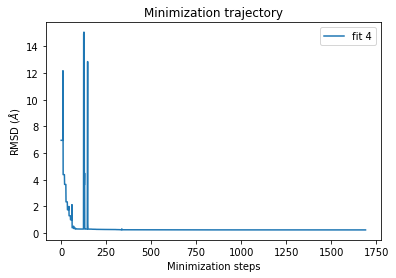

In [39]:
###FIT HELIX 7
fig, ax = plt.subplots()

target_helix_index = 4

print(f"fitting {target_helix_index}")
ph = ParametricHelix(f'fit {target_helix_index}',z_aligned=False)
single_helix_pose = ph.extract_helix(pose,target_helix_index)
single_helix_pose.dump_pdb(f"target_{target_helix_index}.pdb")

fit = ph.fit_target_helix(single_helix_pose, write_axis=True)
#ph.build_helix(-14,16).dump_pdb(f"{target_helix_index}.pdb") #those magic numbers -14 and 16 are the number of residues to build starting from 0, which is in the middle of the fitted helix. So this makes a ~30aa helix
ph.build_helix(-len(single_helix_pose)/2,len(single_helix_pose)).dump_pdb(f"fitted_{target_helix_index}.pdb")
ph.pose().dump_pdb(f"fitted2_{target_helix_index}.pdb")
ax = fit.plot_trajectory_rmsd(ax)

#ax = fit.plot_trajectory_parameter('r0',ax)

fit.write_trajectory_movie(f"movie_{target_helix_index}.pdb")

#print(fit)

In [14]:
#fit.write_trajectory_movie("toroid_outer.pdb")

In [15]:
#I need to catch this divide by zero error, but I haven't been bothered to yet
print(fit.fit.params)

Parameters([('r0', <Parameter 'r0', value=5.0 +/- 9.91e-09, bounds=[5:20]>), ('omega0', <Parameter 'omega0', value=-0.04974188368183839 +/- 0.791, bounds=[-0.17453292519943295:0.17453292519943295]>), ('omega1', <Parameter 'omega1', value=1.795071135676168 +/- 1.08, bounds=[1.3962634015954636:2.0943951023931953]>), ('omega1_omega0_coupling', <Parameter 'omega1_omega0_coupling', value=0.0 +/- 0.304, bounds=[-0.17453292519943295:0.17453292519943295], expr='abs(omega0+omega1)-radians(100)'>), ('phi0', <Parameter 'phi0', value=0.0 (fixed), bounds=[0:inf]>), ('phi1', <Parameter 'phi1', value=-1.4433811355688244 +/- 68, bounds=[-inf:inf]>), ('delta_z', <Parameter 'delta_z', value=0 (fixed), bounds=[-inf:inf]>), ('invert', <Parameter 'invert', value=True (fixed), bounds=[-inf:inf]>), ('translate_x', <Parameter 'translate_x', value=-9.056736390047693 +/- 37.1, bounds=[-inf:inf]>), ('translate_y', <Parameter 'translate_y', value=-28.387703622455426 +/- 322, bounds=[-inf:inf]>), ('translate_z', <

In [8]:
#this block and the next few was written for replacing an existing helix with a new parametrically generated one

#let's make the context structure
xml_obj = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<RESIDUE_SELECTORS>
   <SSElement name="helix7" 
       selection="11,L" 
       to_selection="12,L" 
       chain="A" />
       
    <SSElement name="helixN-7" 
       selection="n_term" 
       to_selection="12,L" 
       chain="A" />
       
    <SSElement name="helix7-C" 
       selection="11,L" 
       to_selection="c_term" 
       chain="A" />
</RESIDUE_SELECTORS>

<MOVERS>
   <DeleteRegionMover name="delete" residue_selector="helix7" rechain="True"/>
   <DeleteRegionMover name="delete_N" residue_selector="helixN-7" rechain="True"/>
   <DeleteRegionMover name="delete_C" residue_selector="helix7-C" rechain="True"/>
</MOVERS>
""")
delete_helix_7 = xml_obj.get_mover("delete")
delete_helix_N_7 = xml_obj.get_mover("delete_N")
delete_helix_7_C = xml_obj.get_mover("delete_C")



In [9]:
context_pose = pyrosetta.Pose()
context_pose.detached_copy(pose)
delete_helix_7.apply(context_pose)

context_pose_C = pyrosetta.Pose()
context_pose_C.detached_copy(pose)
delete_helix_N_7.apply(context_pose_C)

context_pose_N = pyrosetta.Pose()
context_pose_N.detached_copy(pose)
delete_helix_7_C.apply(context_pose_N)

context_pose_N.append_pose_by_jump(context_pose_C,1)
two_chain_context_pose = context_pose_N

context_pose.dump_pdb("check.pdb")
two_chain_context_pose.dump_pdb("tor_12x_drop12.pdb")

True

In [10]:
#make valine!
def make_poly_x(pose,x):
    stm = pyrosetta.rosetta.protocols.simple_moves.SimpleThreadingMover()
    stm.set_sequence(x*len(pose.residues),1)
    stm.apply(pose)

In [11]:
make_poly_x(context_pose,"V")



In [12]:
context_pose.dump_pdb("check2.pdb")

True

In [13]:
fp = copy.deepcopy(ph.get_helix_parameters())

In [14]:
xml_obj = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <RESIDUE_SELECTORS>
       <True name="all"/>
       <SSElement name="left" 
           selection="10,H" 
           to_selection="11,H" 
           chain="A" />

       <SSElement name="right" 
           selection="12,H" 
           to_selection="13,H" 
           chain="A" />
    </RESIDUE_SELECTORS>

    <FILTERS>
        <BuriedSurfaceArea name="BSA" confidence="0" residue_selector="all"/>
        <BuriedSurfaceArea name="BSA_left" confidence="0" residue_selector="left"/>
        <BuriedSurfaceArea name="BSA_right" confidence="0" residue_selector="right"/>
    </FILTERS>
    """)
all_burial = xml_obj.get_filter("BSA")
left_burial = xml_obj.get_filter("BSA_left")
right_burial = xml_obj.get_filter("BSA_right")

In [15]:
def Mr(d_x,d_y,d_z,R):

    M = np.append(np.append(R,[[0]*3],axis=0),[[0]]*4,axis=1)

    M[3][3] = 1
    M[0][3] = d_x
    M[1][3] = d_y
    M[2][3] = d_z
    
    return M

def M(d_x,d_y,d_z,d_phi,d_theta,d_psi):
    R = euler_to_R(d_phi,d_theta,d_psi)

    M = np.append(np.append(R,[[0]*3],axis=0),[[0]]*4,axis=1)

    M[3][3] = 1
    M[0][3] = d_x
    M[1][3] = d_y
    M[2][3] = d_z
    
    return M

def transform(M, coords):
    padded_coords = np.append(coords,[[1]]*coords.shape[0], axis = 1)
    transformed = M.dot(padded_coords.T).T
    striped_transformed = np.delete(transformed,3,axis=1)
    return striped_transformed


def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])



In [17]:
#now let's sample around this fit! 
#if i sample 100,000 helices, I can expect to get 2000 outputs
import tqdm

do_run = True


fp.length(14)


num_phi1 = 6
phi1_range = radians(90)
phi1_start = fp.phi1() - phi1_range
phi1_stop = fp.phi1() + phi1_range
phi1s = np.linspace(phi1_start,phi1_stop,num_phi1)
#phi1s = [fp.phi1()]

num_around_z = 10
around_z_start = -radians(6)
around_z_stop = radians(6)
around_zs = np.linspace(around_z_start, around_z_stop, num_around_z)  #TESTED
#around_zs = [0]

num_along_z = 10
along_z_start = -2.5
along_z_stop = 2
along_zs = np.linspace(along_z_start, along_z_stop, num_along_z) #TESTED
#along_zs = [0]

num_around_v = 25
around_v_range = radians(45)
around_v_start = -radians(25)
around_v_stop = radians(100)
around_vs = np.linspace(around_v_start, around_v_stop, num_around_v) #TESTED
#around_vs = [0]

num_along_v = 8 #was 10
along_v_start = -3.0
along_v_stop = 2.0
along_vs = np.linspace(along_v_start, along_v_stop, num_along_v) #TESTED
#along_vs = [0]

num_tilt = 5
tilt_start = radians(10)
tilt_stop = radians(-30)
tilts = np.linspace(tilt_start,tilt_stop, num_tilt)

scorefxn = pyrosetta.ScoreFunction() 
scorefxn.set_weight(pyrosetta.rosetta.core.scoring.fa_rep, 1.0) 
scorefxn.set_weight(pyrosetta.rosetta.core.scoring.fa_atr, 1.0) 
scorefxn.set_weight(pyrosetta.rosetta.core.scoring.fa_sol, 1.0) 
context_rep = scorefxn(context_pose)

clash_check_pose = pyrosetta.Pose()
acceptable_helices = []
acceptable_helical_parameters = []

num_todo = 0
for along_z in along_zs:
    for around_z in around_zs:
        for along_v in along_vs:
            for around_v in around_vs:
                for phi1 in phi1s:
                    for tilt in tilts: 
                        num_todo += 1

print(f"num_todo! {num_todo}")


bar = tqdm.tqdm_notebook(total = num_todo)
params = []
if do_run:
    
    
    
    left_burial_before = left_burial.report_sm(context_pose)
    right_burial_before = right_burial.report_sm(context_pose)
    
    all_helices = []
    counter = 0
    for along_z in along_zs:
        for around_z in around_zs:
            for along_v in along_vs:
                for around_v in around_vs:
                    for phi1 in phi1s:
                        for tilt in tilts:
                            bar.update(1)
                            params.append((counter,along_z,around_z,along_v,around_v,phi1,tilt))
                            counter += 1

    #                         bar.update(1)
    #                         chp = copy.deepcopy(fp)

    #                         chp.phi1(phi1)

    #                         tph = ParametricHelix()
    #                         tph.set_helix_parameters(chp)

    #                         name=f"{counter}_{along_z:.2f}_{degrees(around_z):.2f}_{along_v:.2f}_{degrees(around_v):.2f}_{degrees(phi1):.2f}"

    #                         cac = tph.Ca_coords_from_stored_params()

    #                         #Math time

    #                         ##along_v aka in/out from current pos
    #                         #I need to define v so I can move in and out
    #                         v = np.mean(cac[:,-3:],axis=0) #don't need z
    #                         v[2] = 0 #I don't think I want to move anything about z

    #                         uv = normalize(v)
    #                         dv_x, dv_y, dv_z = uv * along_v


    #                         ##around_v aka tilt

    #                         Rv = rotation_matrix(uv, around_v)

    #                         #transform wrt v
    #                         cac = transform(Mr(dv_x,dv_y,dv_z,Rv),cac)


    #                         ##along_z aka up/down
    #                         uz = np.array([0,0,1])
    #                         dz_x, dz_y, dz_z = uz * along_z

    #                         ##around_z aka rotate

    #                         Rz = rotation_matrix(uz, around_z)

    #                         #transform wrt z
    #                         cac = transform(Mr(dz_x,dz_y,dz_z,Rz),cac)


    #                         #with open(f"output/test_{name}.pdb",'w') as pdb:
    #                         #    pdb.write(tph.pdb_str_from_Ca(cac))

    #                         helix = tph.pose_from_Ca(cac)
    #                         make_poly_x(helix,"V")

    #                         helix_rep = scorefxn(helix)
    #                         clash_check_pose.detached_copy(context_pose)
    #                         clash_check_pose.append_pose_by_jump(helix,1)
    #                         merged_rep = scorefxn(clash_check_pose)
    #                         diff = merged_rep - (helix_rep + context_rep)
    #                         #print(name, diff)


    #                         #this magic number was arrived at by looking at many and seeing which looked like crap and which didn't
    #                         energy_diff_cutoff = 6000
    #                         if abs(diff) < energy_diff_cutoff or True:

    #                             left_burial_after = left_burial.report_sm(clash_check_pose)
    #                             right_burial_after = right_burial.report_sm(clash_check_pose)
    #                             delta_left = left_burial_after - left_burial_before
    #                             delta_right = right_burial_after - right_burial_before



    #                             if (delta_left > left_thresh and delta_right > right_thresh) or True:
    #                                 with open(f"output/test_{name}.pdb",'w') as pdb:
    #                                     pdb.write(tph.pdb_str_from_Ca(cac))


    #                                 #acceptable_helices.append((name,helix))
    #                                 #acceptable_helical_parameters.append(chp)


    #                         counter += 1
print("done")

num_todo! 600000


/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


done


In [104]:
fp.length()

14

In [115]:
def build_and_judge_params(params):
    counter, along_z, around_z, along_v, around_v, phi1, tilt = params
    chp = copy.deepcopy(fp)
    debug_accept=False
    chp.phi1(phi1)
    accept=False

    tph = ParametricHelix()
    tph.set_helix_parameters(chp)

    name=f"{counter}_{along_z:.2f}_{degrees(around_z):.2f}_{along_v:.2f}_{degrees(around_v):.2f}_{degrees(phi1):.2f}_{degrees(tilt):.2f}"

    cac = tph.Ca_coords_from_stored_params()

    #Math time

    ##along_v aka in/out from current pos
    #I need to define v so I can move in and out
    v = np.mean(cac[:,-3:],axis=0) #don't need z
    v[2] = 0 #I don't think I want to move anything about z

    uv = normalize(v)
    dv_x, dv_y, dv_z = uv * along_v


    ##around_v

    Rv = rotation_matrix(uv, around_v)

    #transform wrt v
    cac = transform(Mr(dv_x,dv_y,dv_z,Rv),cac)


    ##along_z aka up/down
    uz = np.array([0,0,1])
    dz_x, dz_y, dz_z = uz * along_z

    ##around_z aka rotate

    Rz = rotation_matrix(uz, around_z)

    #transform wrt z
    cac = transform(Mr(dz_x,dz_y,dz_z,Rz),cac)
    
    ##tilt
    com = np.mean(cac[:,-3:],axis=0)
    ucom = normalize(com)
    
    """https://stackoverflow.com/questions/11132681/what-is-a-formula-to-get-a-vector-perpendicular-to-another-vector
    If the two vectors are perpendicular then their dot product is zero.

    So: v1(x1, y1, z1), v2(x2, y2, z2).

    => x1 * x2 + y1 * y2 + z1 * z2 = 0
    You know (x1, y1, z1). Put arbitrary x2 andy2 and you will receive the corresponding z2:

    z1 * z2 = -x1 * x2 - y1 * y2
    => z2 = (-x1 * x2 - y1 * y2) / z1
    """
    
    #ah, but given that z componenet will be zero...
    
    
    """https://gamedev.stackexchange.com/questions/70075/how-can-i-find-the-perpendicular-to-a-2d-vector
    To get the 2D vector perpendicular to another 2D vector simply swap the X and Y components, 
    negating the new Y component. So { x, y } becomes { y, -x }.
    """
    
    
    uperp = (ucom[1],-ucom[0],0)
    
    cac_ori = cac - com
    
    cac_ori = np.dot(rotation_matrix(uperp, tilt), cac_ori.T).T
    
    cac = cac_ori + com
    
    #Rt = rotation_matrix(ut, tilt)
    #cac = transform(Mr(0,0,0,Rt),cac)


    #with open(f"output/test_{name}.pdb",'w') as pdb:
        #pdb.write(tph.pdb_str_from_Ca(cac))

    helix = tph.pose_from_Ca(cac)
    make_poly_x(helix,"V")

    helix_rep = scorefxn(helix)
    clash_check_pose.detached_copy(context_pose)
    clash_check_pose.append_pose_by_jump(helix,1)
    merged_rep = scorefxn(clash_check_pose)
    diff = merged_rep - (helix_rep + context_rep)
    #print(name, diff)

    delta_left = 0
    delta_right = 0
    
    left_thresh = 140 #was 92, want it a little higher I think
    right_thresh = 140 #was 92, want it a little higher I think

    #this magic number was arrived at by looking at many and seeing which looked like crap and which didn't
    energy_diff_cutoff = 2500
    #might want to turn that up a little. things are a little too close. Wsa 6000, lets do 
    if abs(diff) < energy_diff_cutoff or debug_accept:

        left_burial_after = left_burial.report_sm(clash_check_pose)
        right_burial_after = right_burial.report_sm(clash_check_pose)
        delta_left = left_burial_after - left_burial_before
        delta_right = right_burial_after - right_burial_before



        if (delta_left > left_thresh and delta_right > right_thresh) or debug_accept:
            accept = True
    
    if not accept:
        helix = None
            

    return (accept, name, diff, delta_left, delta_right, helix)

In [117]:
import multiprocessing
import random

#params = random.sample(params,5000)

print(f"reading {len(params)} params")

#agents = 24
agents=24
chunksize = 6


pool = multiprocessing.Pool(processes=agents)
all_helices = [x for x in tqdm.tqdm_notebook(pool.imap_unordered(build_and_judge_params, params),total=len(params))]
pool.close()
pool.join()

reading 600000 params


/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [118]:
import pickle
pickle.dump( all_helices, open( "all_helices.p", "wb" ) )

In [12]:
import pickle
all_helices = pickle.load(open("all_helices.p","rb"))

In [143]:
import pickle
import gzip
pickle.dump( all_helices, gzip.open( "all_helices.p.gz", "wb" ) )

In [ ]:
import pickle
import gzip
all_helices = pickle.load(gzip.open("all_helices.p.gz","rb"))

In [16]:
hit_count = 0
for h in all_helices:
    if h[0]:
        hit_count += 1
print(hit_count)

17250


In [17]:
accepted_helices = [h for h in all_helices if h[0]]

In [18]:
import pickle
pickle.dump( accepted_helices, open( "accepted_helices.p.gz", "wb" ) )

In [16]:
import pickle
accepted_helices = pickle.load(open("accepted_helices.p.gz","rb"))

In [17]:
len(accepted_helices)

17250

In [122]:
top_4k = sorted(accepted_helices, key=lambda x: x[3] + x[4],reverse=True)[:4000]

In [123]:
top_4k[0]

(True,
 '321009_0.00_-2.00_-0.14_-25.00_-136.70_-30.00',
 2161.401065252903,
 204.4814021713105,
 203.19936863000294,
 <pyrosetta.rosetta.core.pose.Pose at 0x7fff78381148>)

In [124]:
top_4k[-1]

(True,
 '371262_0.50_-4.67_2.00_-25.00_-100.70_-10.00',
 667.0307613382756,
 173.7314001937475,
 188.59640821807716,
 <pyrosetta.rosetta.core.pose.Pose at 0x7fff537e3f10>)

In [139]:
import random
random.shuffle(top_4k)
for h in top_4k[:100]:
    helix = h[-1]
    name = h[1]
    helix.append_pose_by_jump(two_chain_context_pose,2)
    helix.dump_pdb(f"output/tor_12x_d12_{name}.pdb")

In [126]:
df = pd.DataFrame(top_4k,columns=["accept","name","clash","left_burial","right_burial","pose"])

In [138]:
df[df.name.str.contains("161990")]

,accept,name,clash,left_burial,right_burial,pose


In [134]:
df[df.name.str.contains("442604")]

,accept,name,clash,left_burial,right_burial,pose


In [137]:
df[df.name.str.contains("447054")]

,accept,name,clash,left_burial,right_burial,pose
3999,True,447054_1.00_-0.67_-0.14_-19.79_-28.70_-30.00,1412.351798,191.668118,175.780774,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."


In [136]:
df

,accept,name,clash,left_burial,right_burial,pose
0,True,376601_0.50_-3.33_1.29_-9.37_-100.70_0.00,704.904945,188.343762,176.807811,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
1,True,201782_-1.00_-2.00_0.57_-19.79_-172.70_-10.00,2290.912710,208.577799,159.121389,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
2,True,453762_1.00_0.67_0.57_-25.00_-100.70_-10.00,673.561042,234.040477,144.518428,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
3,True,423781_1.00_-6.00_0.57_-19.79_-172.70_0.00,2057.212135,155.024992,213.708283,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
4,True,370501_0.50_-4.67_1.29_-25.00_-172.70_0.00,1091.028280,188.332010,190.138139,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
...,...,...,...,...,...,...
3995,True,370512_0.50_-4.67_1.29_-25.00_-100.70_-10.00,1542.291105,175.780774,200.130009,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
3996,True,550530_2.00_-4.67_1.29_-19.79_-172.70_10.00,1417.747162,178.857184,185.012355,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
3997,True,447073_1.00_-0.67_-0.14_-14.58_-100.70_-20.00,1973.112774,218.836417,175.525777,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."
3998,True,321818_0.00_-2.00_0.57_-14.58_-136.70_-20.00,707.589828,181.673897,187.049977,"(Residue 1: VAL:NtermProteinFull (VAL, V):\nBa..."


In [140]:
import random
random.shuffle(accepted_helices)
for h in accepted_helices[:100]:
    helix = h[-1]
    name = h[1]
    helix.append_pose_by_jump(two_chain_context_pose,2)
    helix.dump_pdb(f"output/all_accepted_tor_12x_d12_{name}.pdb")

In [18]:
#write all the poses!
accepted_helices

last_partition = -1

for i, h in enumerate(accepted_helices):
    partition = int(np.floor(i / 2000))
    helix = h[-1]
    name = h[1]
    
    if partition != last_partition:
        print(partition)
        os.makedirs(f"output/{partition}",exist_ok=True)
        last_partition = partition
    fname = f"output/{partition}/tor_12x_d12_{name}.pdb.gz"
    if not os.path.exists(fname):
        #print(partition)
        helix.append_pose_by_jump(two_chain_context_pose,2)
        helix.dump_pdb(fname)

0
1
2
3
4
5
6
7
8
